<center style='font-size:28px;'><u><b>Making Business Decisions Based on Data</b></u></center>

# Project description

<ul>A big online store has a list of hypotheses that may help boost revenue.</ul>
<ul>The project is about prioritize these hypotheses, launch an A/B test, and analyze the results.</ul>
<div><b>In particular:</b></div>

- Utilise ICE and RICE methodologies, and compare their effect
- Visualise various metrics, cumulative metrics and relative differences
- Calculate percentiles
- Find statistical significances for metric differences
- Make conclusions and conjectures
- Make a decision based on the test results

## Description of the data

- **hypotheses**
<ul>Hypothesis — brief descriptions of the hypotheses</ul>
<ul>Reach — user reach, on a scale of one to ten</ul>
<ul>Impact — impact on users, on a scale of one to ten</ul>
<ul>Confidence — confidence in the hypothesis, on a scale of one to ten</ul>
<ul>Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.</ul>

- **orders**
<ul>transactionId — order identifier</ul>
<ul>visitorId — identifier of the user who placed the order</ul>
<ul>date — of the order</ul>
<ul>revenue — from the order</ul>
<ul>group — the A/B test group that the user belongs to</ul>

- **visits**
<ul>date — date</ul>
<ul>group — A/B test group</ul>
<ul>visits — the number of visits on the date specified in the A/B test group specified</ul>


*Data needs to be preprocessed as **there might be mistakes in the original datasets**; for example, some of the visitors might have gotten into both group A and group B*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Opening files

In [2]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv')
except:
    hypotheses = pd.read_csv('https://code.s3.yandex.net/datasets/hypotheses_us.csv')
try:
    orders = pd.read_csv('orders_us.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_us.csv')
try:
    visits = pd.read_csv('visits_us.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_us.csv')

## `Hypotheses`

In [3]:
hypotheses.head()

,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. T...
1,Launch your own delivery service. This will sh...
2,Add product recommendation blocks to the store...
3,Change the category structure. This will incre...
4,Change the background color on the main page. ...


Seems the lines are quite long..

In [4]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes


Its not clear what that one column exactly contain. Before looking into it, casting has to be done.

In [5]:
hypotheses['Hypothesis;Reach;Impact;Confidence;Effort'] = hypotheses['Hypothesis;Reach;Impact;Confidence;Effort'].astype('string')
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      string
dtypes: string(1)
memory usage: 200.0 bytes


In [6]:
rows = []
for j in range(0,9):
    rows.append(hypotheses.iloc[j,0])
rows

['Add two new channels for attracting traffic. This will bring 30% more users;3;10;8;6',
 'Launch your own delivery service. This will shorten delivery time;2;5;4;10',
 "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size;8;3;7;3",
 'Change the category structure. This will increase conversion since users will find the products they want more quickly;8;3;3;8',
 'Change the background color on the main page. This will increase user engagement;3;1;1;1',
 'Add a customer review page. This will increase the number of orders;3;2;2;3',
 'Show banners with current offers and sales on the main page. This will boost conversion;5;3;8;3',
 'Add a subscription form to all the main pages. This will help you compile a mailing list;10;7;8;5',
 'Launch a promotion that gives users discounts on their birthdays;1;9;9;5']

So everything is split by ';' just as the name of the column hints. A new table - <code>hypos</code> - will present the information clearer; The original table will be kept as is.

In [7]:
lst = []
for j in range(len(rows)):
    tmp_row = rows[j].split(';')
    lst.append(tmp_row)
    
cols = hypotheses.columns[0].split(';')
hypos = pd.DataFrame(columns=cols, data=lst)
hypos

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


Its not gonna be too convenient to work closely with the hypotheses once they're ready to analysis, so an auxiliary table is introduced - <code>hyp_aux</code>, one that displays the full hypotheses's text clearly. In turn the full hypothesis in <code>hypos</code> is replaced by the hypothesis ID.

In [8]:
for j in range(len(hypos)):
    hypos.replace(hypos['Hypothesis'][j],'H{j}'.format(j=j),inplace=True)

hyp_aux = []
for j in range(len(rows)):
    h = rows[j].split(';')[0]
    h = 'H{j} - '.format(j=j) + h
    hyp_aux.append(h)

In [9]:
hypos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      object
 2   Impact      9 non-null      object
 3   Confidence  9 non-null      object
 4   Effort      9 non-null      object
dtypes: object(5)
memory usage: 488.0+ bytes


In [10]:
hypos = hypos.astype({'Hypothesis' : 'string','Reach' : 'int64','Impact' : 'int64','Confidence' : 'int64','Effort' : 'int64'})
hypos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      string
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), string(1)
memory usage: 488.0 bytes


So whats left is the <code>hypos</code> table storing RICE and "hypothesis ID", and <code>hyp_aux</code> with the full hypothesis and matching ID's (a list of strings)

In [11]:
hypos

,Hypothesis,Reach,Impact,Confidence,Effort
0,H0,3,10,8,6
1,H1,2,5,4,10
2,H2,8,3,7,3
3,H3,8,3,3,8
4,H4,3,1,1,1
5,H5,3,2,2,3
6,H6,5,3,8,3
7,H7,10,7,8,5
8,H8,1,9,9,5


In [12]:
hyp_aux

['H0 - Add two new channels for attracting traffic. This will bring 30% more users',
 'H1 - Launch your own delivery service. This will shorten delivery time',
 "H2 - Add product recommendation blocks to the store's site. This will increase conversion and average purchase size",
 'H3 - Change the category structure. This will increase conversion since users will find the products they want more quickly',
 'H4 - Change the background color on the main page. This will increase user engagement',
 'H5 - Add a customer review page. This will increase the number of orders',
 'H6 - Show banners with current offers and sales on the main page. This will boost conversion',
 'H7 - Add a subscription form to all the main pages. This will help you compile a mailing list',
 'H8 - Launch a promotion that gives users discounts on their birthdays']

## `orders`

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [14]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


Some casting needs to be done

In [15]:
orders = orders.astype({'date': 'datetime64[ns]','group': 'string'})
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   string        
dtypes: datetime64[ns](1), float64(1), int64(2), string(1)
memory usage: 46.9 KB


### Pre-Processing

In [16]:
print(f'Number of duplicated - {orders.duplicated().sum()}')
tmp = len(orders[orders['revenue'] <= 1])
print(f'Num of suspicious orders (pre-processing-wise) - {tmp}')
print(f'All orders between {orders.date.min()} to {orders.date.max()}')
tmp = len(orders[orders['transactionId'] == 0])
print(f"Num of faulty payment ID's - {tmp}")
tmp = len(orders[orders['visitorId'] == 0])
print(f"Num of faulty user ID's - {tmp}")
print('Unique payments -',orders['transactionId'].nunique())
print('Unique visitors -',orders['visitorId'].nunique())

Number of duplicated - 0
Num of suspicious orders (pre-processing-wise) - 0
All orders between 2019-08-01 00:00:00 to 2019-08-31 00:00:00
Num of faulty payment ID's - 0
Num of faulty user ID's - 0
Unique payments - 1197
Unique visitors - 1031


Each visitor is responsible for at least one transaction. In addition, some users bought more than once.

<div>As mentioned, the A/B group selection might contain errors, specifically - some of the visitors might have gotten into both group A and group B. Those users are to be find, preferably deleted; However, if there are too many of them it'll be too problematic and the test would probably better start all over again from the A/A stage.</div>

In [17]:
orda = orders[orders['group'] == 'A']
ordb = orders[orders['group'] == 'B']
ordab = orda.merge(ordb, on='visitorId',how='inner')
AB_users = orda.merge(ordb,on='visitorId')['visitorId'].unique()
len(AB_users)

58

In [18]:
len(orders[orders['visitorId'].isin(AB_users)])

181

The problematic data makes 15% of total transactions and 5% of distinct users. An abnormal AB user made about 181/58 = 3 purchases, compared with the normal user (A user who's exclusively belongs to either A or B) who made just (1031-58)/(1197-181)=0.96=1 order in average. Maybe because those users were so active it confused who set up the test. Or all users had their group change, but only those 58 abnormal users were able to buy something before the mix.
Either way, the proportion is low enough so that its possible to delete those abnormal-users records and continue with the A/B test.

In [19]:
orders = orders[~orders['visitorId'].isin(AB_users)]
orders.group.value_counts()

B    548
A    468
Name: group, dtype: Int64

<p>The groups are'nt equal, by about 20%. However, seems like its OK (Tutor comment in slack - <b>"This should not affect the conversion rate) As for the average check, the difference should not be that big to really influence the test, you can use sampling technique or not, it's not a big deal in this specific case".</b> I myself don't have any idea actually..</p> 

`orders` is cleared for analysis. <code>orda</code> and <code>ordb</code> are introduced for ease of analysis later

In [20]:
orda = orders[orders['group'] == 'A']
ordb = orders[orders['group'] == 'B']

## `visits`

In [21]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [22]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [23]:
visits = visits.astype({'date': 'datetime64[ns]', 'group': 'string'})
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     string        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), string(1)
memory usage: 1.6 KB


### Pre-Processing

In [24]:
print(f'Number of duplicated - {visits.duplicated().sum()}')
tmp = len(visits[visits['visits'] <= 1])
print(f'Num of suspicious visits (pre-processing-wise) - {tmp}')
print(f'All visits between {visits.date.min()} to {visits.date.max()}')
visits.group.value_counts()

Number of duplicated - 0
Num of suspicious visits (pre-processing-wise) - 0
All visits between 2019-08-01 00:00:00 to 2019-08-31 00:00:00


B    31
A    31
Name: group, dtype: Int64

In [25]:
print(len(visits[visits['group'] == 'A']['date'].value_counts()))
print(len(visits[visits['group'] == 'B']['date'].value_counts()))

31
31


Now its witnessed that for each group there are 31 rows, one row for each day in August. Visits is cleared. <code>visa</code> and <code>visb</code> are introduced for ease of analysis later:

In [26]:
visa = visits[visits['group'] == 'A']
visb = visits[visits['group'] == 'B']

## Pre-Processing summation

- <b>Users with records in both A and B groups were deleted. The data left is good enough for the test to continue</b>
- <b>Auxiliary tables were introduced for ease of analysis - <code>orda</code>, <code>ordb</code>, <code>visa</code> and <code>visb</code></b>
- <b>Turns out all <code>orders</code> and <code>visits</code> information is of August 2019</b>

# Prioritizing Hypotheses

In [27]:
hypos['ICE'] = (hypos['Impact'] * hypos['Confidence'] / hypos['Effort'])
hypos.sort_values('ICE',ascending=False,inplace=True)
hypos

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
8,H8,1,9,9,5,16.200000
0,H0,3,10,8,6,13.333333
7,H7,10,7,8,5,11.200000
6,H6,5,3,8,3,8.000000
2,H2,8,3,7,3,7.000000
1,H1,2,5,4,10,2.000000
5,H5,3,2,2,3,1.333333
3,H3,8,3,3,8,1.125000
4,H4,3,1,1,1,1.000000


In [28]:
hypos['RICE'] = hypos['Reach'] * hypos['Impact'] * hypos['Confidence'] / hypos['Effort']
hypos.sort_values('RICE',ascending=False,inplace=True)
hypos

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,H7,10,7,8,5,11.200000,112.0
2,H2,8,3,7,3,7.000000,56.0
0,H0,3,10,8,6,13.333333,40.0
6,H6,5,3,8,3,8.000000,40.0
8,H8,1,9,9,5,16.200000,16.2
3,H3,8,3,3,8,1.125000,9.0
1,H1,2,5,4,10,2.000000,4.0
5,H5,3,2,2,3,1.333333,4.0
4,H4,3,1,1,1,1.000000,3.0


As witnessed, choosing RICE over ICE (or the other way round) changes prioritization of hypotheses: H8 and H0 top the ICE table, but with a pretty low reach they plunge, overall a third of the RICE of H7, the winner. H7's ICE was 1.5 times less than that of ICE table 1st place - H8, but with 10 times bigger REACH it surpassed it by 10/1.5=6.6 ~= 112/16.2 times. As H7 is so far in front, there's no doubt that's the task adviced to do next.

In [29]:
hyp_aux[7]

'H7 - Add a subscription form to all the main pages. This will help you compile a mailing list'

Make sense. Predictable total-reach task, with high impact.

# A/B Test Analysis

- **Graph cumulative revenue by group. Make conclusions and conjectures**

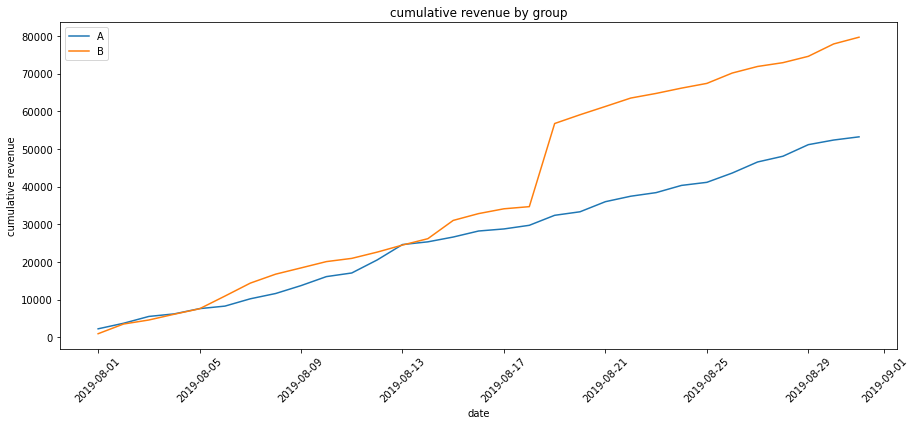

In [30]:
orda_grouped_cumrev = orda.groupby('date')['revenue'].sum().cumsum().reset_index()
orda_grouped_cumrev.columns = ['date','cumrev']
ordb_grouped_cumrev = ordb.groupby('date')['revenue'].sum().cumsum().reset_index()
ordb_grouped_cumrev.columns = ['date','cumrev']

plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orda_grouped_cumrev['date'], orda_grouped_cumrev['cumrev'], label='A')
plt.plot(ordb_grouped_cumrev['date'], ordb_grouped_cumrev['cumrev'], label='B')
plt.legend()
plt.title('cumulative revenue by group')
plt.xlabel('date')
plt.ylabel('cumulative revenue')
plt.xticks(rotation=45)
plt.show()

Both groups are about the same for the first 2 weeks, with a small advantage for the B group. After that, the B group cumulative revenue jumps, while continuing to grow at around the same speed as before. There's a good chance that one jump at 19/08 is due to a single purchase, so it shouldn't be regarded to the difference between the groups. However, B group is consistently getting further away from the A graph, so that's a good sign the hypothesis is true.

- **Graph cumulative average order size by group. Make conclusions and conjectures**

In [31]:
orda_grouped_cumord = orda.groupby('date')['revenue'].count().cumsum().reset_index()
orda_grouped_cumord.columns = ['date','cumord']
a = orda_grouped_cumrev.merge(orda_grouped_cumord,on='date')
a['cumul_avch']=a['cumrev']/a['cumord']

ordb_grouped_cumord = ordb.groupby('date')['revenue'].count().cumsum().reset_index()
ordb_grouped_cumord.columns = ['date','cumord']
b = ordb_grouped_cumrev.merge(ordb_grouped_cumord,on='date')
b['cumul_avch']=b['cumrev']/b['cumord']

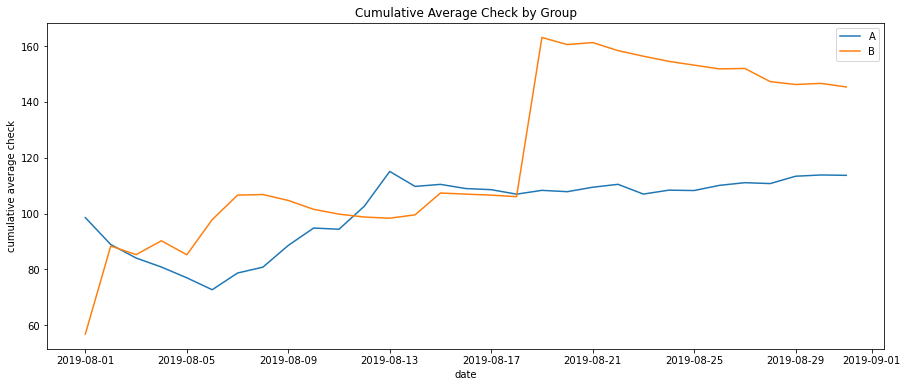

In [32]:
plt.plot(a['date'], a['cumul_avch'], label='A')
plt.plot(b['date'], b['cumul_avch'], label='B')
plt.legend()
plt.title('Cumulative Average Check by Group')
plt.xlabel('date')
plt.ylabel('cumulative average check')
plt.show()

The results are ambiguous - the first half of the test doesn't have a clear winner as both groups take the lead at some stage; Whereas the second half of the test has a clear winner, but its due to a probably single order that could have been made by a user from A group equally the same. Moreover, at this part of the test where B take the lead, its cumulative average check actually inclined down, while A's cumulative average check inclined up.

- **Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures**

In [33]:
rel_cum_avch = a.merge(b,on='date')
rel_cum_avch['rel'] = rel_cum_avch['cumul_avch_y']/rel_cum_avch['cumul_avch_x']-1
rel_cum_avch.head()

,date,cumrev_x,cumord_x,cumul_avch_x,cumrev_y,cumord_y,cumul_avch_y,rel
0,2019-08-01,2266.6,23,98.547826,967.2,17,56.894118,-0.422675
1,2019-08-02,3734.9,42,88.926190,3535.3,40,88.382500,-0.006114
2,2019-08-03,5550.1,66,84.092424,4606.9,54,85.312963,0.014514
3,2019-08-04,6225.6,77,80.851948,6138.5,68,90.272059,0.116511
4,2019-08-05,7623.6,99,77.006061,7587.8,89,85.256180,0.107136


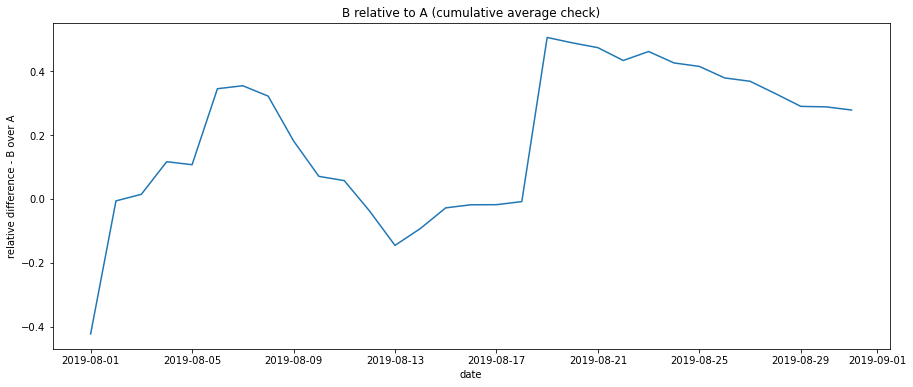

In [34]:
plt.plot(rel_cum_avch['date'], rel_cum_avch['rel'])
plt.title('B relative to A (cumulative average check)')
plt.xlabel('date')
plt.ylabel('relative difference - B over A')
plt.show()

Reminds some motives from earlier - first two weeks are'nt clear, and afterwards B takes the lead but simultaneously has a less and less positive difference over A. So, its too ambiguous to conclude anything

- **Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures**

In [35]:
orda_per_day = orda.groupby('date')['revenue'].count().reset_index()
orda_per_day.columns = ['date','orders']
ordb_per_day = ordb.groupby('date')['revenue'].count().reset_index()
ordb_per_day.columns = ['date','orders']

cona  = visa.merge(orda_per_day,on='date')
conb  = visb.merge(ordb_per_day,on='date')
cona['conversion'] = cona['orders']/cona['visits']
conb['conversion'] = conb['orders']/conb['visits']

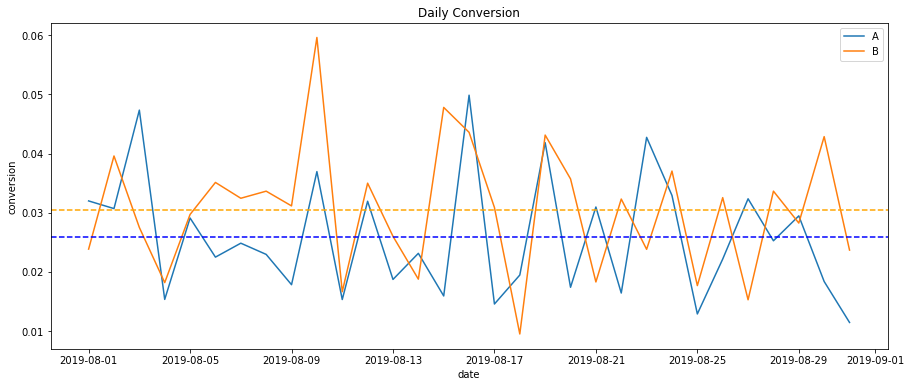

In [36]:
plt.plot(cona['date'], cona['conversion'], label='A')
plt.plot(conb['date'], conb['conversion'], label='B')
plt.axhline(y=cona['conversion'].mean(), color='b', linestyle='--')
plt.axhline(y=conb['conversion'].mean(), color='orange', linestyle='--')
plt.legend()
plt.title('Daily Conversion')
plt.xlabel('date')
plt.ylabel('conversion')
plt.show()

Conversion itself varies considerably between 1% to 6%, for both groups. However, B's conversion is mostly better - Around 15% higher than A's one. That's a very good sign for the hypothesis.

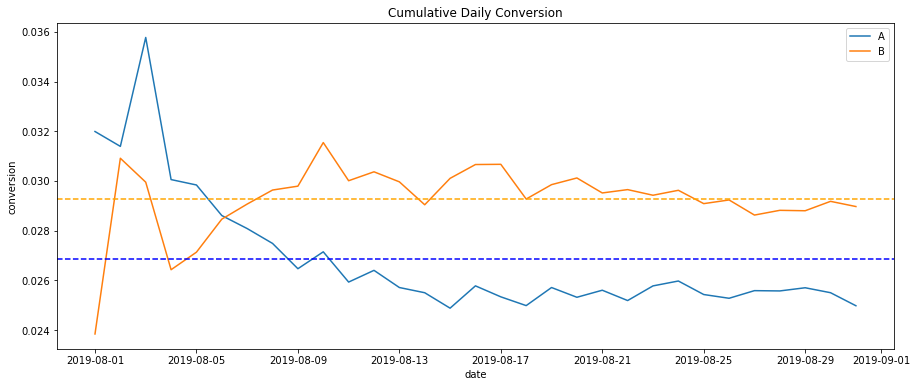

In [37]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date':'max', 'group':'max', 'transactionId':pd.Series.nunique, 'visitorId':pd.Series.nunique, 'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1
)

ordersAggregated=ordersAggregated.sort_values(by=['date','group'])
visitorsAggregated=visitorsAggregated.sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(
   visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns=['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData['conversion']=cumulativeData['orders']/cumulativeData['visitors']

cuma = cumulativeData[cumulativeData['group'] == 'A']
cumb = cumulativeData[cumulativeData['group'] == 'B']

plt.plot(cuma['date'], cuma['conversion'], label='A')
plt.plot(cumb['date'], cumb['conversion'], label='B')
plt.axhline(y=cuma['conversion'].mean(), color='b', linestyle='--')
plt.axhline(y=cumb['conversion'].mean(), color='orange', linestyle='--')
plt.legend()
plt.title('Cumulative Daily Conversion')
plt.xlabel('date')
plt.ylabel('conversion')
plt.show()

Overall, B's cumulative conversion's better, by 2/27 = 7.5%. Its twice less better than the daily case, but still significantly better.

- **Plot a scatter chart of the number of orders per user. Make conclusions and conjectures**

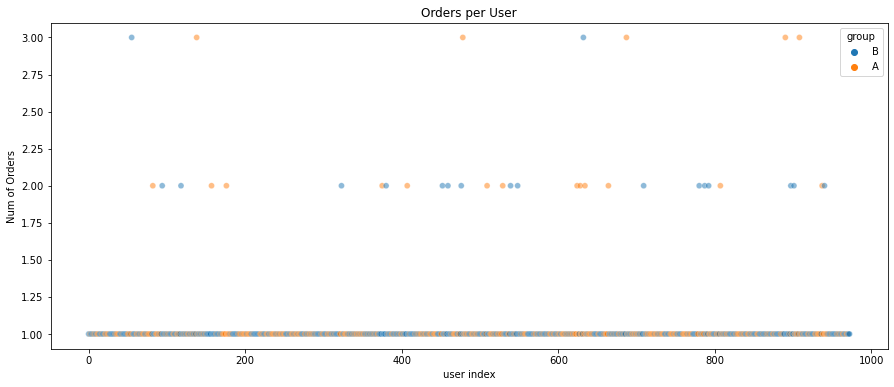

In [38]:
orders_per_user = orders.groupby(['visitorId','group'])['revenue'].count().reset_index().reset_index()
sns.scatterplot(x = "index", y = "revenue", data = orders_per_user, hue = "group",alpha=.5)
plt.title('Orders per User')
plt.xlabel('user index')
plt.ylabel('Num of Orders')
plt.show()

Seems the absolute majority of buyers bought only once.

- **Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.**

In [39]:
orders_per_user.revenue.value_counts()

1    937
2     29
3      7
Name: revenue, dtype: int64

In [40]:
print('95th percentile -',orders_per_user.quantile(.95))
print('99th percentile -',orders_per_user.quantile(.99))

95th percentile - index        9.234000e+02
visitorId    4.029952e+09
revenue      1.000000e+00
Name: 0.95, dtype: float64
99th percentile - index        9.622800e+02
visitorId    4.233005e+09
revenue      2.000000e+00
Name: 0.99, dtype: float64


No point in cutting by index, and thus declare some users with 2 orders as viable while declaring others with the same number of orders as not. Therefore, the choice is whether or not to include users with 2 orders in the filtered data (users with 3 orders are without a doubt an anomaly). 29 / 966 = 0.03 i.e 3%. It sounds like not so much, and the profit will be to have a really clean data to base conclusions upon. So, <b>users with more than 1 order will be considered an anomaly.</b>

- **Plot a scatter chart of order prices. Make conclusions and conjectures.**

In [41]:
orders.revenue.describe()

count     1016.000000
mean       130.770866
std        648.079810
min          5.000000
25%         20.775000
50%         50.100000
75%        126.950000
max      19920.400000
Name: revenue, dtype: float64

So IQR = 106, Q3 + 1.5*IQR = 127 + 159 = 286. No bottom border for outliers. The mean is greater than Q3 so there's obviously a serious effect of outliers here.

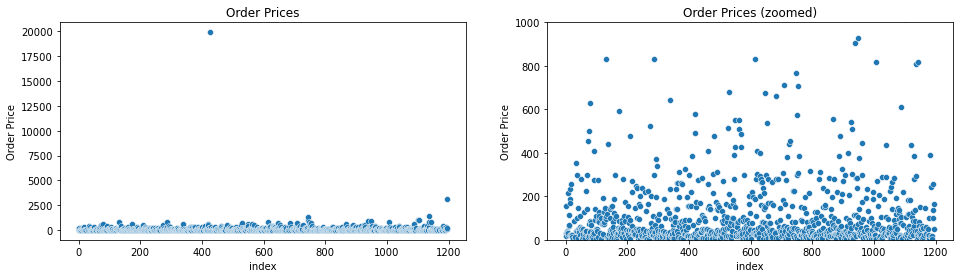

In [42]:
fig = plt.figure(figsize=(16,4))

plt.subplot(121)
plt.title('Order Prices')
plt.xlabel('index')
plt.ylabel('Order Price')
sns.scatterplot(data = orders.reset_index(), x = 'index', y = 'revenue')

plt.subplot(122)
plt.title('Order Prices (zoomed)')
plt.xlabel('index')
plt.ylabel('Order Price')
plt.ylim(0, 1000)
sns.scatterplot(data = orders.reset_index(), x = 'index', y = 'revenue')

plt.show()

Seems the absolute majority of orders are of less than 1200 dollars, with only a few orders that cost more. The lower thick line upper bound is way less, around 200. Between 300 to 400 there's less but not a negligible amount of orders

- **Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly**

In [43]:
print('95th percentile -',orders.revenue.quantile(.95))
print('99th percentile -',orders.revenue.quantile(.99))

95th percentile - 414.275
99th percentile - 830.3


Both much bigger than the previously suggested Q3+1.5IQR = 286 bound. Taking the latter as bound would remove more than 5% of the data. To prevent that, and not losing way more than 5%, **the upper bound will be set as 400 dollars.**

- **Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.**

## Total Conversion

In [44]:
a_successes = cona.orders.sum()
b_successes = conb.orders.sum()
a_trials = cona.visits.sum()
b_trials = conb.visits.sum()

In [45]:
def check_hypothesis(successes1,trials1, successes2,trials2, alpha=0.05):
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')

- <b>H<sub>0</sub></b> - difference in total conversion distributions between A and B is statistically insignificant
- <b>H<sub>1</sub></b> - difference in total conversion distributions between A and B is statistically significant
- $\alpha$ = 0.05

In [46]:
check_hypothesis(a_successes,a_trials, b_successes,b_trials, alpha=0.05)

p-value:  0.016851380434703023
Reject H0


Earlier, a 15% difference between the overall groups's conversions was witnessed. So, its not a surprise.

## Daily Conversion

In [47]:
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')

- <b>H<sub>0</sub></b> - differences in conversion between A and B are statistically insignificant
- <b>H<sub>1</sub></b> - differences in conversion between A and B are statistically significant
- $\alpha$ = 0.05

In [48]:
testing_average(cona['conversion'],conb['conversion'],alpha=0.05)

0.09573715593918651
Fail to Reject H0


Earlier, the graphs for daily conversion looked pretty similar. Without those mean lines it was hard to tell exactly which group is better. So it makes sense the test didn't reject the null hypothesis, as that hypothesis might be true, even when the total conversions are definitely not the same.<p><b>However, sampling might change this result</b></p>

In [49]:
orders_by_usersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
orders_by_usersA.columns = ['userId', 'orders']

orders_by_usersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
orders_by_usersB.columns = ['userId', 'orders']

sampleA = pd.concat([orders_by_usersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(orders_by_usersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([orders_by_usersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(orders_by_usersB['orders'])), name='orders')],axis=0)

In [51]:
testing_average(sampleA,sampleB,alpha=0.05)

0.0055090420550073455
Reject H0


C:\Users\idanm\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


So, after sampling, results align with total conversion - Turns out the difference is by good chance significant

- **Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures**

In [52]:
print("A's mean revenue -",orda.revenue.mean())
print("B's mean revenue -",ordb.revenue.mean())

A's mean revenue - 113.70085470085463
B's mean revenue - 145.34890510948907


B group has greater overall average check, bigger than A's average check by almost 30%, its a lot.

In [53]:
orda_per_day = orda.groupby('date')['revenue'].count().reset_index()
orda_per_day.columns = ['date','orders']
ordb_per_day = ordb.groupby('date')['revenue'].count().reset_index()
ordb_per_day.columns = ['date','orders']

In [54]:
reva_per_day = orda.groupby('date')['revenue'].sum().reset_index()
avcha = reva_per_day.merge(orda_per_day,on='date')
avcha['avch'] = avcha['revenue']/avcha['orders']
revb_per_day = ordb.groupby('date')['revenue'].sum().reset_index()
avchb = revb_per_day.merge(ordb_per_day,on='date')
avchb['avch'] = avchb['revenue']/avchb['orders']

In [55]:
print("A's mean average check -",avcha['avch'].mean())
print("B's mean average check -",avchb['avch'].mean())

A's mean average check - 115.51247176082741
B's mean average check - 138.37116968351648


Also when taking the mean by day, B's average check is still much bigger.

- <b>H<sub>0</sub></b> - difference in average-check distributions between A and B are statistically insignificant
- <b>H<sub>1</sub></b> - difference in average-check distributions between A and B are statistically significant
- $\alpha$ = 0.05

In [56]:
testing_average(avcha['avch'],avchb['avch'],alpha=0.05)

0.4775457158686006
Fail to Reject H0


Results are surprising. B's average check is so much bigger that H0 was predicted to be rejected. Maybe outliers have something to do with it

- **Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures**

## Filtering Data

First, data needs to be filtered - users with more than 1 order and orders exceeding 400 dollars are to be filtered out

In [57]:
big_users = orders.groupby('visitorId')['revenue'].count().reset_index()
big_users = big_users[big_users['revenue'] != np.percentile(orders_per_user['revenue'], 95)]
big_users.revenue.sum()

79

In [58]:
orders_new = orders[~orders['visitorId'].isin(big_users['visitorId'])]
orders_new

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


Thats great, because 1016- 79 = 937, so first step of filtering done

In [59]:
big_orders = orders_new[orders_new['revenue'] > np.percentile(orders['revenue'], 95)]
len(big_orders)

50

All those records should be deleted, while other orders from users appearing here should be kept. Luckily, from the pre-processing its known all transaction Id's are unique. So, all those above 400 (practically, top 5% orders) dollars records could be deleted by their transactionId.

In [60]:
orders_new = orders_new[~orders_new['transactionId'].isin(big_orders['transactionId'])]
orders_new

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A


And data is filtered. Tables for calculating conversion and average check need to be updated.

In [61]:
orda_new = orders_new[orders_new['group'] == 'A']
ordb_new = orders_new[orders_new['group'] == 'B']
orda_per_day_new = orda_new.groupby('date')['revenue'].count().reset_index()
orda_per_day_new.columns = ['date','orders']
ordb_per_day_new = ordb_new.groupby('date')['revenue'].count().reset_index()
ordb_per_day_new.columns = ['date','orders']

cona_new  = visa.merge(orda_per_day_new,on='date')
conb_new  = visb.merge(ordb_per_day_new,on='date')
cona_new['conversion'] = cona_new['orders']/cona_new['visits']
conb_new['conversion'] = conb_new['orders']/conb_new['visits']

## Total Conversion

In [62]:
a_successes_new = cona_new.orders.sum()
b_successes_new = conb_new.orders.sum()
a_trials_new = cona_new.visits.sum()
b_trials_new = conb_new.visits.sum()

- <b>H<sub>0</sub></b> - difference in total conversions for A and B are statistically insignificant (filtered data)
- <b>H<sub>1</sub></b> - difference in total conversions for A and B are statistically significant (filtered data)
- $\alpha$ = 0.05

In [63]:
check_hypothesis(a_successes_new,a_trials_new, b_successes_new,b_trials_new, alpha=0.05)

p-value:  0.016199413442176347
Reject H0


p-value is a bit smaller, and still smaller by 3 times than the alpha value.

In [64]:
a_successes_new / a_trials_new

0.021669513236549958

In [65]:
b_successes_new / b_trials_new

0.02542820892366251

B's total conversion rate is bigger by 16%, so accordingly H0 is rejected.

## Daily Conversion

- <b>H<sub>0</sub></b> - difference in daily conversions between A and B are statistically insignificant (filtered data)
- <b>H<sub>1</sub></b> - difference in daily conversions between A and B are statistically significant (filtered data)
- $\alpha$ = 0.05

In [66]:
testing_average(cona_new['conversion'],conb_new['conversion'],alpha=0.05)

0.021674782335834378
Reject H0


Seems like without outliers the conversions differ. Its not what we got earlier, but its not overwhelming as B's total conversion is much bigger. Seems like outliers prevented the rejection of H0 earlier.

In [67]:
orders_by_usersA_fil = orders_new[orders_new['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
orders_by_usersA_fil.columns = ['userId', 'orders']

orders_by_usersB_fil = orders_new[orders_new['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
orders_by_usersB_fil.columns = ['userId', 'orders']

sampleA_fil = pd.concat([orders_by_usersA_fil['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(orders_by_usersA_fil['orders'])), name='orders')],axis=0)

sampleB_fil = pd.concat([orders_by_usersB_fil['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(orders_by_usersB_fil['orders'])), name='orders')],axis=0)

In [68]:
testing_average(sampleA_fil,sampleB_fil,alpha=0.05)

0.008100454286571687
Reject H0


C:\Users\idanm\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In this case, sampling don't change the result

- **Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures**

In [69]:
print("A's mean revenue -",orda_new.revenue.mean())
print("B's mean revenue -",ordb_new.revenue.mean())

A's mean revenue - 80.74679802955667
B's mean revenue - 78.05821205821198


Earlier B's mean was much bigger. Now they're about the same, with B's mean even smaller.

In [70]:
reva_per_day_new = orda_new.groupby('date')['revenue'].sum().reset_index()
avcha_new = reva_per_day_new.merge(orda_per_day_new,on='date')
avcha_new['avch'] = avcha_new['revenue']/avcha_new['orders']
revb_per_day_new = ordb_new.groupby('date')['revenue'].sum().reset_index()
avchb_new = revb_per_day_new.merge(ordb_per_day_new,on='date')
avchb_new['avch'] = avchb_new['revenue']/avchb_new['orders']

In [71]:
print("A's mean average check -",avcha_new['avch'].mean())
print("B's mean average check -",avchb_new['avch'].mean())

A's mean average check - 83.34409768573194
B's mean average check - 79.63247781334981


Now its clear outliers had B so much in front of A's average check earlier, both overall and daily. Averages are about the same with B's average smaller by 4%

- <b>H<sub>0</sub></b> - difference in average-checks between A and B are statistically insignificant (filtered data)
- <b>H<sub>1</sub></b> - difference in average-checks between A and B are statistically significant (filtered data)
- $\alpha$ = 0.05

In [72]:
testing_average(avcha_new['avch'],avchb_new['avch'],alpha=0.05)

0.5868740020824459
Fail to Reject H0


Now it all makes sense. The averages for both overall and daily average-checks are pretty close, and indeed H0 is not rejected. Turns out it was indeed outliers that earlier, when calculating the same for the raw data, made the surprising result.

- **Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test**

## Test Evaluation

- Average check
<div>All results concerning average check were pretty ambiguous, besides one that turned out to be affected a lot by outliers. The plots for cumulative average check and "B relative to A average check" had the same motive - B had some single high order that made it go past A, and following that jump B's numbers were in a shallow dive whereas A's numbers were going up. The plot for cumulative revenue share the motive of the jump at 19/08 with the latters, however in its case the incline for B was better. But that was before filtering the data.</div>
- Conversion Rate
<div>all results showed B's in favor - the statistic checks for overall and daily conversion as well as the daily conversion plot. The overall conversion of B is bigger than A's conversion by 16%, which is pretty decisive</div>
- Conclusion
<p>A new feature was tested by the B group, while A group was the control.</p>
<p>Results for both average check and conversion are consistent - No apparent effect of the new feature tested on average check; A clear and positive effect of it on conversion.</p>
<p>Therefore, the test is adviced to stop. The information gathered is likely the right one. <b>B is good for conversion, but has no effect on average check.</b> That should be remembered before putting B into action </p>